In [132]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [70]:
cwd = os.getcwd()
path_data = os.path.join(cwd,"data","pump_sensor.csv")
df = pd.read_csv(path_data,index_col=0)

# The task
- Using sensor data to predict the breakdowns of machines

# Ideas how to approach the issue:
- using pca to condense the multitude of sensors into meaningful aggregates
- fitting dynamic processes and checking, which sensors deviate from their dynmics at broken points
- splitting breakdowns into train and test using say 5 and 2 respectively seems prohibitive 
- looking at deviations from mean and/or median of normal values at the time of a breakdown to uncover good indicators 
- looking at specific times/dates

In [71]:
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [72]:
df.loc[:,"timestamp"] = pd.to_datetime(df.timestamp)
df = df.set_index("timestamp")

In [73]:
df.shape

(220320, 53)

In [74]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [75]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

- There are very few break-downs.
- It is unclear what recovering means, most likely it is the phases after a breakdown.

In [76]:
df.machine_status[df.machine_status=="RECOVERING"]

timestamp
2018-04-12 21:56:00    RECOVERING
2018-04-12 21:57:00    RECOVERING
2018-04-12 21:58:00    RECOVERING
2018-04-12 21:59:00    RECOVERING
2018-04-12 22:00:00    RECOVERING
                          ...    
2018-07-25 15:11:00    RECOVERING
2018-07-25 15:12:00    RECOVERING
2018-07-25 15:13:00    RECOVERING
2018-07-25 15:14:00    RECOVERING
2018-07-25 15:15:00    RECOVERING
Name: machine_status, Length: 14477, dtype: object

- Recovery-timestamps come in sequences

In [111]:
broken = df.machine_status == "BROKEN"
recovery = df.machine_status == "RECOVERY"
normal = df.machine_status == "NORMAL"


When did the breakdowns happen?

In [112]:
broken_tstamps = df.index[broken]
broken_tstamps

DatetimeIndex(['2018-04-12 21:55:00', '2018-04-18 00:30:00',
               '2018-05-19 03:18:00', '2018-05-25 00:30:00',
               '2018-06-28 22:00:00', '2018-07-08 00:11:00',
               '2018-07-25 14:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

- during warm or cold seasons, depending on the part of the globe

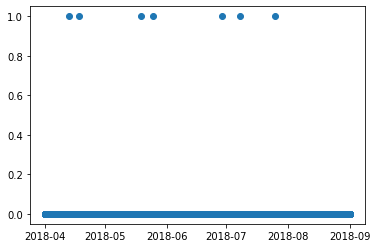

In [88]:
plt.scatter(x=df.index,y=broken)

sensor_15    1.000000
sensor_50    0.349569
sensor_51    0.069821
sensor_00    0.046333
sensor_07    0.024741
sensor_08    0.023180
sensor_06    0.021777
sensor_09    0.020856
sensor_01    0.001675
sensor_30    0.001185
dtype: float64


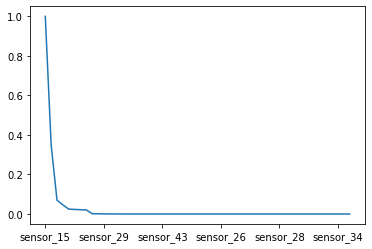

In [89]:
perc_na = df.isna().mean().sort_values(ascending=False)
perc_na.plot()
print(perc_na.iloc[:10])


There are no observations for sensor_15, we drop it.

In [90]:
df = df.drop(["sensor_15"],axis=1)

In [91]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


- There are different units of measurement.


In [92]:
sensor_cols = [col for col in df.columns if col.startswith("sensor")]

In [93]:
scaler = StandardScaler()
df.loc[:,sensor_cols] = scaler.fit_transform(df.loc[:,sensor_cols])

In [94]:
df.loc[:,sensor_cols]

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0.226024,-0.151548,0.639359,1.057629,0.303430,0.177090,-0.041631,0.130935,0.179843,0.121570,...,-0.358948,-0.176788,-0.260504,1.759525,0.185877,-0.588606,0.086292,0.553104,0.919519,-0.011961
2018-04-01 00:01:00,0.226024,-0.151548,0.639359,1.057629,0.303430,0.177090,-0.041631,0.130935,0.179843,0.121570,...,-0.358948,-0.176788,-0.260504,1.759525,0.185877,-0.588606,0.086292,0.553104,0.919519,-0.011961
2018-04-01 00:02:00,0.175906,-0.072552,0.639359,1.093518,0.334771,0.008646,-0.081751,0.088217,0.204698,0.100824,...,-0.358948,-0.200367,-0.285498,1.736986,0.204376,-0.588605,0.061664,0.522874,0.892914,0.009162
2018-04-01 00:03:00,0.214089,-0.151548,0.627523,1.093517,0.260034,0.207684,-0.085093,0.183521,0.243753,0.135404,...,-0.384330,-0.271105,-0.310494,1.691906,0.204376,-0.588606,0.061664,0.507759,0.879613,0.003881
2018-04-01 00:04:00,0.178293,-0.138383,0.639359,1.093517,0.317895,0.184560,-0.068376,0.167089,0.243753,0.135404,...,-0.384330,-0.223946,-0.335489,1.714445,0.241374,-0.533186,0.089811,0.492644,0.906216,-0.011961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,0.085218,0.032772,-0.094513,-0.252232,0.305841,-0.509039,0.747363,0.367557,0.222446,0.173441,...,-0.511246,-0.506895,2.214014,0.722703,0.019383,-0.311513,0.747710,5.042211,NaN,0.259995
2018-08-31 23:56:00,0.068511,0.032772,-0.082675,-0.252232,0.279321,-0.437200,0.764079,0.390563,0.222446,0.152690,...,-0.536628,-0.506895,2.089039,0.587466,0.000884,-0.339222,0.765300,5.178246,NaN,0.259995
2018-08-31 23:57:00,0.058966,0.032772,-0.094513,-0.252232,0.244765,-0.352751,0.733993,0.390563,0.243753,0.152690,...,-0.511246,-0.436158,1.964063,0.452228,0.000884,-0.339222,0.807518,5.132899,NaN,0.267917


In [98]:
def perc_median_shifts(df):
    """ returns percentage median changes over normal median changes when a 
    breakdown takes place
    
    """
    df_broken = df[df.machine_status=="BROKEN"]
    df_normal = df[df.machine_status=="NORMAL"]
    result = (df_broken.median(axis=0)-df_normal.median(axis=0))/df_normal.median(axis=0)
    result = result.abs().sort_values(ascending=False)
    return result

In [99]:
df_perc_shift = perc_median_shifts(df)

In [102]:
df_perc_shift.head(10)

sensor_00    16.159705
sensor_29    15.159734
sensor_38    12.455168
sensor_04    10.016415
sensor_42     7.885965
sensor_51     7.880268
sensor_06     7.740047
sensor_05     6.816057
sensor_10     5.084781
sensor_34     4.385063
dtype: float64

In [140]:
heaviest_first = list(df_perc_shift.index)

In [154]:
def plot_i_heaviest_shift(i):
    ax = df.loc[:,heaviest_first[i]].plot(ls='-',lw=1)
    ymin = df.loc[:,heaviest_first[i]].min().min()
    ymax = ymin = df.loc[:,heaviest_first[i]].max().max()
    #ax.vlines(x=broken_tstamps, colors='red', ls='-', lw=5, label='vline_multiple',ymin=ymin, ymax=ymax)
    plt.scatter(x = broken_tstamps, y = df.loc[:,heaviest_first[i]].loc[broken], color="red")


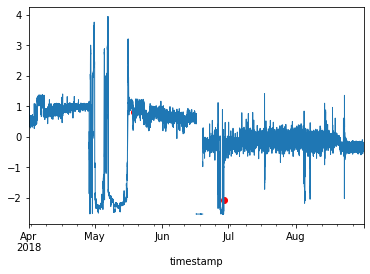

In [155]:
plot_i_heaviest_shift(1)